=== Сравнение моделей на тестовой выборке ===


,Модель,Accuracy (test),F1 macro (test)
0,LogisticRegression,0.986,0.9850
1,RandomForest,0.958,0.9547



=== Подробные метрики (RandomForest) ===
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



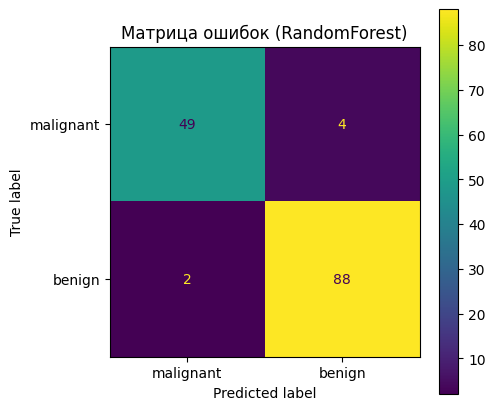


Прогноз для одной записи из тестовой выборки:
Класс: benign | Вероятность benign: 0.99


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#
# классификация на 2 класса (доброкачественная / злокачественная)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

# Делим на обучающую и тестовую выборки
# stratify=y — чтобы пропорции классов сохранились одинаковыми в train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Собираем две модели для сравнения

# Модель №1: логистическая регрессия + стандартизация признаков
lr = Pipeline([
    ("scaler", StandardScaler()),  # приводим признаки к одному масштабу
    ("clf", LogisticRegression(max_iter=3000, random_state=42))
])

# Модель №2: случайный лес (ансамбль деревьев решений)
rf = RandomForestClassifier(n_estimators=300, random_state=42)

# Обучаем модели
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Предсказания на тестовой выборке
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

# Сравнение моделей в таблице
results = pd.DataFrame([
    {
        "Модель": "LogisticRegression",
        "Accuracy (test)": accuracy_score(y_test, lr_pred),
        "F1 macro (test)": f1_score(y_test, lr_pred, average="macro"),
    },
    {
        "Модель": "RandomForest",
        "Accuracy (test)": accuracy_score(y_test, rf_pred),
        "F1 macro (test)": f1_score(y_test, rf_pred, average="macro"),
    },
]).round(4).sort_values("F1 macro (test)", ascending=False)

print("=== Сравнение моделей на тестовой выборке ===")
display(results)

# Подробный отчёт по метрикам (для RandomForest)
print("\n=== Подробные метрики (RandomForest) ===")
print(classification_report(y_test, rf_pred, target_names=data.target_names))

# График: матрица ошибок (Confusion Matrix)
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format="d")
plt.title("Матрица ошибок (RandomForest)")
plt.show()

# 9) Прогноз для одной строки из тестовой выборки (демонстрация predict_proba)
sample = X_test.iloc[[0]]
prob_benign = rf.predict_proba(sample)[0, 1]  # вероятность класса benign
pred = rf.predict(sample)[0]

print("\nПрогноз для одной записи из тестовой выборки:")
print("Класс:", data.target_names[pred], "| Вероятность benign:", round(float(prob_benign), 4))


In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Собираем метрики в одну таблицу (macro — усреднение по классам)
metrics_table = pd.DataFrame([
    {
        "Модель": "LogisticRegression",
        "Accuracy": accuracy_score(y_test, lr_pred),
        "Precision (macro)": precision_score(y_test, lr_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_test, lr_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_test, lr_pred, average="macro"),
    },
    {
        "Модель": "RandomForest",
        "Accuracy": accuracy_score(y_test, rf_pred),
        "Precision (macro)": precision_score(y_test, rf_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_test, rf_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_test, rf_pred, average="macro"),
    }
]).round(4).sort_values("F1 (macro)", ascending=False)

print("=== Таблица метрик на тестовой выборке ===")
display(metrics_table)


=== Таблица метрик на тестовой выборке ===


,Модель,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,LogisticRegression,0.986,0.9850,0.9850,0.9850
1,RandomForest,0.958,0.9587,0.9512,0.9547


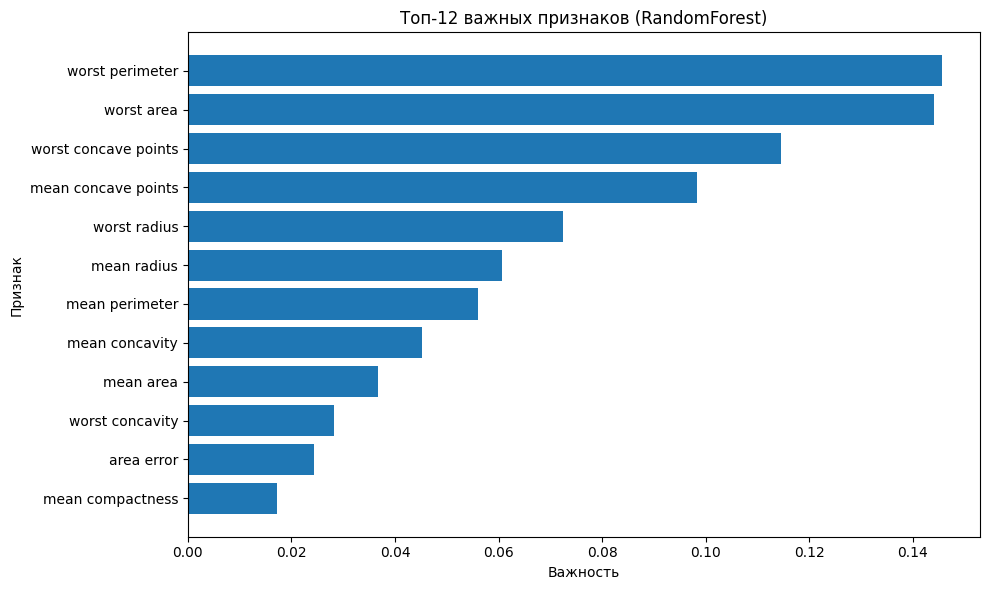

=== Топ-12 признаков (таблица) ===


,Признак,Важность
0,worst perimeter,0.145686
1,worst area,0.144090
2,worst concave points,0.114607
3,mean concave points,0.098307
4,worst radius,0.072351
5,mean radius,0.060713
6,mean perimeter,0.055987
7,mean concavity,0.045211
8,mean area,0.036753
9,worst concavity,0.028162


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Важность признаков у RandomForest
importances = rf.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({
    "Признак": feature_names,
    "Важность": importances
}).sort_values("Важность", ascending=False).head(12)

# Горизонтальный график
plt.figure(figsize=(10, 6))
plt.barh(imp_df["Признак"][::-1], imp_df["Важность"][::-1])
plt.title("12 важных признаков (RandomForest)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

print("=== 12 признаков ===")
display(imp_df.reset_index(drop=True).round(6))
